In [1]:
import time
import math
from math import *
import numpy as np
import scipy
from scipy import special
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = np.loadtxt('ACH.dat')

In [146]:
Lbox = 1100
hLbox = Lbox/2

Nt = 114528
#Nt = 100000
nbar = Nt / Lbox**3

nk = 7
fbasis = np.zeros(nk+1)

nr = 21
rmin = 60
rmax = 120
rmid = (rmax+rmin)/2
mu = rmid
sigma = 4.6
c = -mu/sigma

In [147]:
sample = np.random.choice(len(data),size=Nt,replace=False)

In [148]:
x, y, z = data[sample].T

In [149]:
def E1(s):
    return special.erf(s/sqrt(2))

def E2(s):
    return sqrt(2/pi)*np.exp(-s**2/2)

def f0(s):
    return s**0

def f1(s):
    return (s+1/s) * E1(s) + E2(s)

def f2(s):
    return 3 + s**2

def f3(s):
    return (s**3+6*s+3/s) * E1(s) + (s**2+5) * E2(s)

def f4(s):
    return s**4+10*s**2+15

def f5(s):
    return (s**5+15*s**3+45*s+15/s) * E1(s) + (s**2+3)*(s**2+11) * E2(s)

def f6(s):
    return s**6 + 21*s**4 + 105*s**2 + 105

def f7(s):
    return (s**7+28*s**5+210*s**3+420*s+105/s)* E1(s) + (s**6+27*s**4+185*s**2+279)*E2(s)

def f8(s):
    return s**8 + 36*s**6 + 378*s**4 + 1260*s**2 + 945

#def f9(s):
 #   return (s**9+45*s**7+630*s**5+3150*s**3+4725*s+945/s)*E1(s) + (s**8+44*s**6+588*s**4+2640*s**2+2895)*E2(s)

In [150]:
f = [f0,f1,f2,f3,f4,f5,f6,f7]

In [151]:
def nu0(s):
    return f0(s)

def nu1(s):
    res = 0
    for l in range(2):
        res += scipy.special.comb(1,l) * c**(1-l) * f[l](s)
    return res

def nu2(s):
    res = 0
    for l in range(3):
        res += scipy.special.comb(2,l) * c**(2-l) * f[l](s)
    return res

def nu3(s):
    res = 0
    for l in range(4):
        res += scipy.special.comb(3,l) * c**(3-l) * f[l](s)
    return res

def nu4(s):
    res = 0
    for l in range(5):
        res += scipy.special.comb(4,l) * c**(4-l) * f[l](s)
    return res

def nu5(s):
    res = 0
    for l in range(6):
        res += scipy.special.comb(5,l) * c**(5-l) * f[l](s)
    return res

def nu6(s):
    res = 0
    for l in range(7):
        res += scipy.special.comb(6,l) * c**(6-l) * f[l](s)
    return res

def nu7(s):
    res = 0
    for l in range(8):
        res += scipy.special.comb(7,l) * c**(7-l) * f[l](s)
    return res

def nu8(s):
    res = 0
    for l in range(9):
        res += scipy.special.comb(8,l) * c**(8-l) * f[l](s)
    return res

#def nu9(s):
 #   res = 0
     #for l in range(10):
        #res += scipy.special.comb(9,l) * c**(9-l) * f[l](s)
    #return res

In [152]:
nu = [nu0,nu1,nu2,nu3,nu4,nu5,nu6,nu7]

In [153]:
t0 = time.time()

Nb = np.zeros(nr)

for i in tqdm(range(Nt-1)):
    j = np.arange(i+1,Nt)
    
    dx = x[i] - x[j]
    dy = y[i] - y[j]
    dz = z[i] - z[j]
        
    ### periodic boundary conditions on separations: 
    dx[np.where(dx>hLbox)] -= Lbox
    dy[np.where(dy>hLbox)] -= Lbox
    dz[np.where(dz>hLbox)] -= Lbox
    dx[np.where(dx<-hLbox)] += Lbox
    dy[np.where(dy<-hLbox)] += Lbox
    dz[np.where(dz<-hLbox)] += Lbox

    r2 = dx**2 + dy**2 + dz**2
    r = np.sqrt(r2)
    
    ### bin pair counts:
    hi, bins = np.histogram(r, bins=nr, range=(rmin,rmax))
    Nb += hi
    
    ### Laguerre pair counts:
    r = r[(r>=rmin) & (r<=rmax)]
    if len(r) > 0:
        s = r/sigma
        for k in range(nk+1):
            fbasis[k] += np.sum(nu[k](s))/Nt
    
        
fbasis = fbasis*2 / (Nt-1)
    

t1 = time.time() 
print('Time =', t1-t0)

100%|██████████| 114527/114527 [14:38<00:00, 130.40it/s]

Time = 878.3108966350555


In [154]:
DD = 2*Nb

dr = bins[1] - bins[0]
rbin = (bins[1:] + bins[:-1])/2

RR = (Nt-1)*nbar*4*pi/3*(bins[1:]**3-bins[:-1]**3)
        
xi12 = DD/RR - 1  

sqrtN = np.sqrt(2*Nb)
errxi = sqrtN/RR

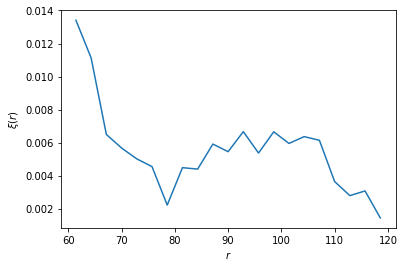

In [155]:
### plot binned xi:
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.show()

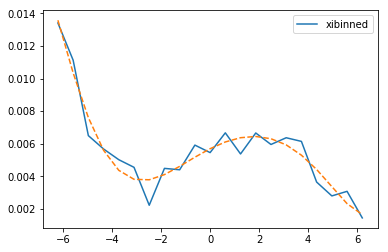

In [156]:
### check if a polynomial is an ok fit to it:
xbin = (rbin - mu)/sigma
aFit = np.polyfit(xbin, xi12, nk)
p = np.poly1d(aFit)
plt.plot(xbin,Xi12, xbin, p(xbin), '--')
plt.legend(["xibinned"])
plt.show()

In [157]:
### setting up the vector of RR:
V = np.zeros(nk+1)
for k in range(nk+1):
    fun = lambda r: r**2 * nu[k](r/sigma)
    V[k] = quad(fun,rmin, rmax)[0]

    
nuRR = 4*pi/Lbox**3*V[0:nk+1]

In [158]:
### the corresponding F_RR:
dim = (nk+1, nk+1)
FRR = np.zeros(dim)
for k in range(nk+1):
    for l in range(k,nk+1):
        func = lambda r: r**2 * nu[k](r/sigma) * nu[l](r/sigma)
        FRR[k,l] = (4*pi/Lbox**3)*quad(func, rmin, rmax)[0]
        FRR[l,k] = FRR[k,l]

In [159]:
invF = np.linalg.inv(FRR)

In [160]:
nuDD = fbasis
simDiff = nuDD - nuRR
aSim = np.zeros(nk+1)
aSim = np.dot(invF, simDiff)
print ('Sim:', aSim)
checkDiff = 0*simDiff
for k in range(nk+1):
    checkDiff[k] = sum(FRR[k,:]*aSim[:])

Sim: [  5.90559771e-03   8.54423168e-04  -2.01107111e-04  -2.25005552e-05
   7.95803041e-06  -1.50469931e-06  -4.63583609e-08   2.07481719e-08]


In [161]:
rt = np.arange(60,121)
yt = rt/sigma
xiSim = 0.0*rt
for k in range(nk+1):
    xiSim += aSim[k] * nu[k](yt)

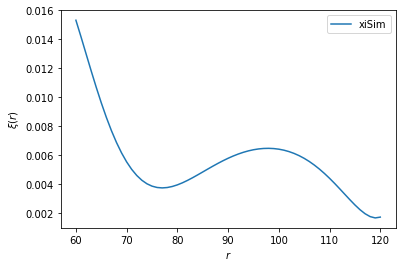

In [162]:
### plot unbinned Laguerre fit: 
plt.plot(rt,xiSim)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["xiSim"])
plt.show()

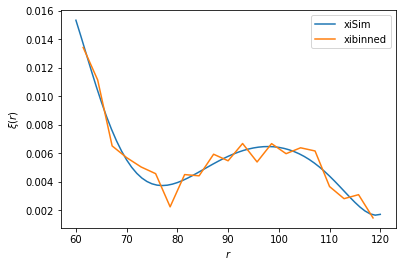

In [163]:
plt.plot(rt,xiSim)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["xiSim", "xibinned"])
plt.show()

In [164]:
ytable = (rt-mu)/sigma
xipoly = 0.0*rt
for k in range(nk+1):
    xipoly += aSim[k] * ytable**(k)

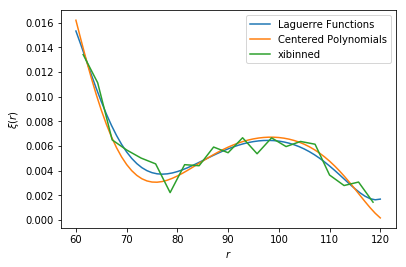

In [165]:
plt.plot(rt,xiSim)       ### the whole data
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

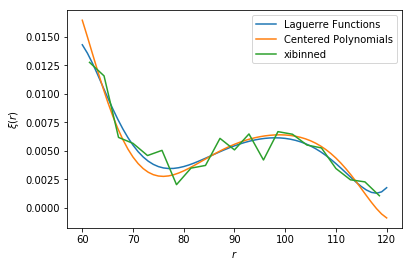

In [145]:
plt.plot(rt,xiSim)        ### (1) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

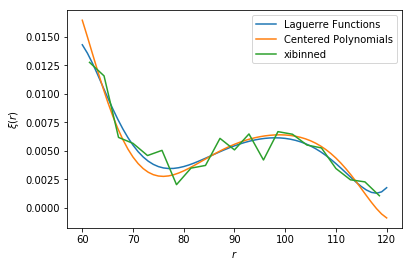

In [132]:
plt.plot(rt,xiSim)        ### (2) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

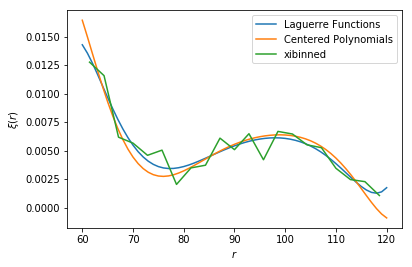

In [119]:
plt.plot(rt,xiSim)        ### (3) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

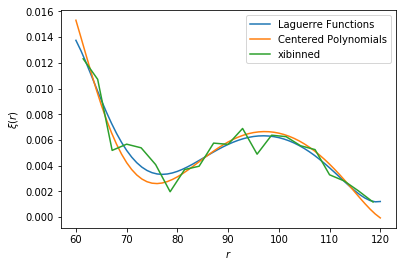

In [99]:
plt.plot(rt,xiSim)        ### (4) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

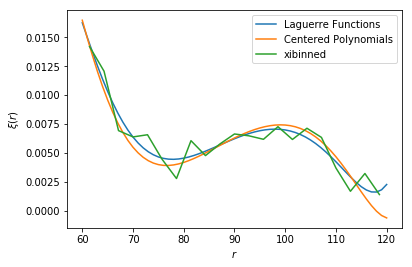

In [79]:
plt.plot(rt,xiSim)        ### (5) Nt = 10^5
plt.plot(rt,xipoly)
plt.plot(rbin,xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["Laguerre Functions", "Centered Polynomials", "xibinned"])
plt.show()

In [166]:
k = np.arange(nk+1)
coef = np.zeros(nk+1)
for i in range(nk+1):
    coef[i] = math.factorial(i)*aSim[i] 

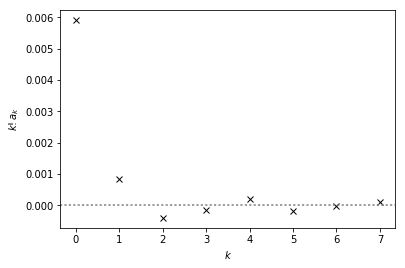

In [167]:
plt.plot(k, coef, 'x', color='black')
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.ylabel(r'$k! a_k$')
plt.xlabel(r'$k$')
plt.show()